## ЗАДАНИЕ
    Скачайте материалы к занятию.
    Проанализируйте ряды и сделайте их стационарными.
    Пришлите решение в виде ссылки на GitHub с ноутбуком.

## 1. Подготовка

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
# функция теста Дики-Фуллера - использовал для посмотреть в процессе тренировки
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
# функция для построения графиков - использовал для посмотреть в процессе тренировки
def tsplot(y, lags=None, figsize=(10, 5), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [4]:
# загрузка данных
airlines =      pd.read_csv("./Series/international-airline-passengers.csv")['Count']
births =        pd.read_csv("./Series/daily-total-female-births-in-cal.csv")['Count']
temperature =   pd.read_csv("./Series/mean-monthly-air-temperature-deg.csv")['Deg']
robberies =     pd.read_csv("./Series/monthly-boston-armed-robberies-j.csv")['Count']
sales =         pd.read_csv("./Series/monthly-sales-of-company-x-jan-6.csv")['Count']
dowjones =    pd.read_csv("./Series/weekly-closings-of-the-dowjones-.csv")['Close']

In [5]:
# создаю словарь с данными 
series = {
    "Monthly sales of company X": sales,
    "Monthly Boston armed robberies": robberies,
    "International airline passengers": airlines,
    "Mean monthly air temperature": temperature,
    "Weekly closings of the Dow-Jones": dowjones,
    "Daily total female births in California": births
}

## 2. Смотрю на графики рядов

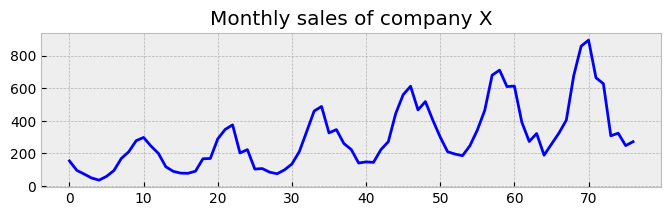

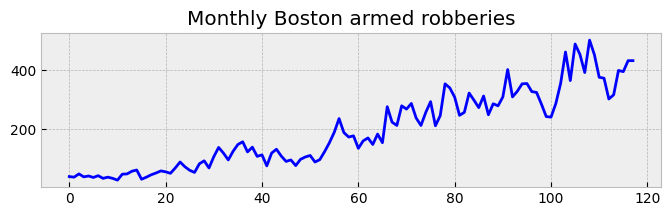

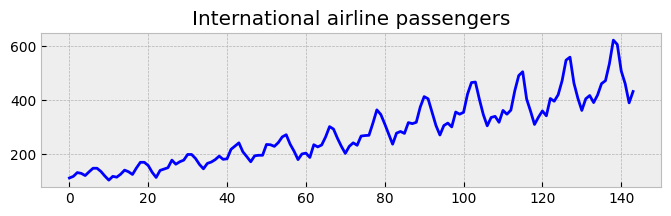

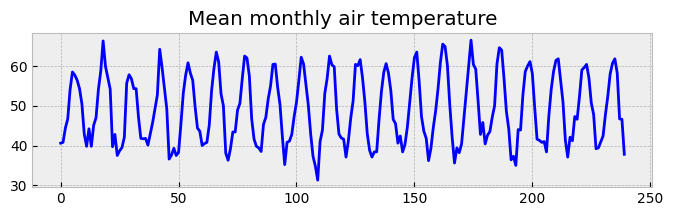

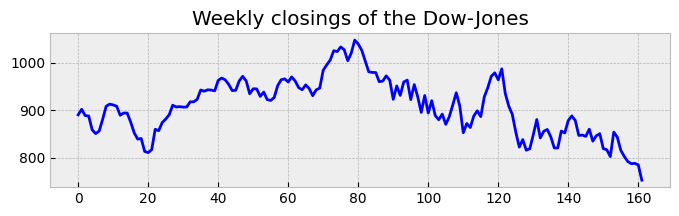

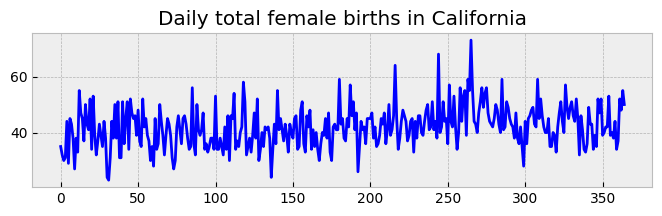

In [6]:
# функция для графиков по всем сериям сразу
def charts (series):
  for key, value in series.items():
    with plt.style.context('bmh'):
      plt.figure(figsize=(8, 2))
      plt.plot(value, color='blue')
      plt.title(key)
charts (series)

#### Похоже, что как минимум 2 ряда уже стационарны, но это нужно проверить.

## 3. "В лоб" проверяю стационарность по тесту Дики-Фуллера

In [7]:
# функция проверки стационарности с цветным выводом https://habr.com/ru/sandbox/158854/
def df_test(series):    
  for series_key, series_val in series.items():
    p = round(adfuller(series_val, autolag='AIC')[1], 4)
    print(f"{series_key}\tp-value={p}")
    if p < 0.05:
      print(f"\033[32m OK \t - ряд стационарен \033[0m \n")
      # print("OK")
    else:
      print(f"\033[33m NOK \t - ряд  НЕ стационарен \033[0m \n")
df_test(series)      

Monthly sales of company X	p-value=0.9889
 NOK 	 - ряд  НЕ стационарен  

Monthly Boston armed robberies	p-value=0.9943
 NOK 	 - ряд  НЕ стационарен  

International airline passengers	p-value=0.9919
 NOK 	 - ряд  НЕ стационарен  

Mean monthly air temperature	p-value=0.017
 OK 	 - ряд стационарен  

Weekly closings of the Dow-Jones	p-value=0.6225
 NOK 	 - ряд  НЕ стационарен  

Daily total female births in California	p-value=0.0001
 OK 	 - ряд стационарен  



#### 2 из 4-х рядов уже стационарны, с остальными 4 нужно работать

In [8]:
# удаляю стационарные ряды из словаря
del series['Mean monthly air temperature']
del series['Daily total female births in California']
series.keys()

dict_keys(['Monthly sales of company X', 'Monthly Boston armed robberies', 'International airline passengers', 'Weekly closings of the Dow-Jones'])

## 4. Работаю с рядами

### 4.1. Применяю к оставшимся рядам преобразование Бокса-Кокса, чтьобы убрать изменение дисперсии

In [9]:
for key,value in series.items():
    series[key] = boxcox(value, 0)
df_test(series)   

Monthly sales of company X	p-value=0.7853
 NOK 	 - ряд  НЕ стационарен  

Monthly Boston armed robberies	p-value=0.2808
 NOK 	 - ряд  НЕ стационарен  

International airline passengers	p-value=0.4224
 NOK 	 - ряд  НЕ стационарен  

Weekly closings of the Dow-Jones	p-value=0.6691
 NOK 	 - ряд  НЕ стационарен  



##### ряды не стали стационарными, хотя значения p-value уменьшились. Если применить преобразование несколько раз, то значения уменьшаются сильнее, однако делать это до бесконечности нельзя, поэтому для чистоты эксперимента преобразую только один раз.

### 4.2. Дифференцирую

In [10]:
# фунция для дифференциации
def diff(series):
 series_diff = series[1:] - series[:-1]
 return series_diff

In [11]:
for key,value in series.items():
  series[key] = diff(value)

In [12]:
df_test(series)

Monthly sales of company X	p-value=0.024
 OK 	 - ряд стационарен  

Monthly Boston armed robberies	p-value=0.0
 OK 	 - ряд стационарен  

International airline passengers	p-value=0.0711
 NOK 	 - ряд  НЕ стационарен  

Weekly closings of the Dow-Jones	p-value=0.0
 OK 	 - ряд стационарен  



##### 3 ряда стали стационарными, один по-прежнему нестационарен
##### Смотрю на него внимательнее

In [13]:
airlines = series['International airline passengers']

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


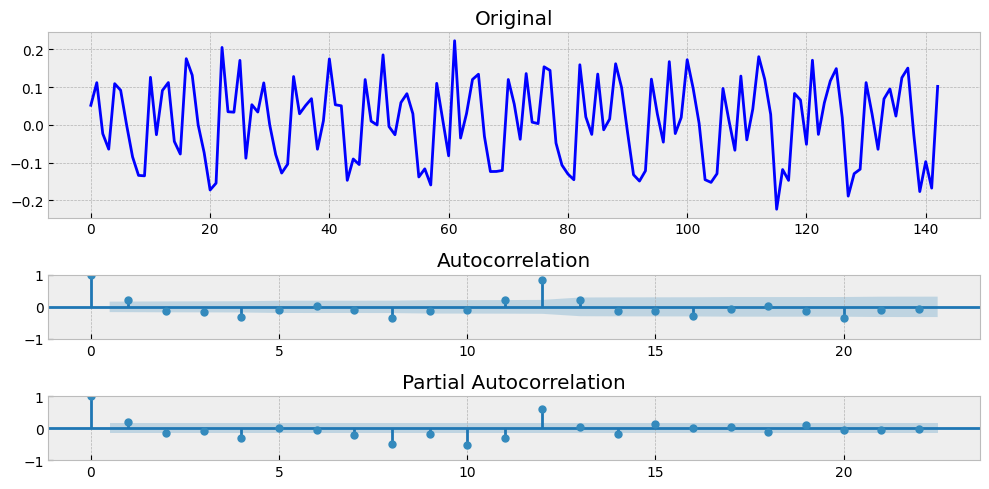

In [14]:
tsplot(airlines)

##### наблюдается сезонность 12 месяцев, которую нужно убрать

### 4.3. Убираю сезонность

In [15]:
airlines = airlines[12:] - airlines[:-12]

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


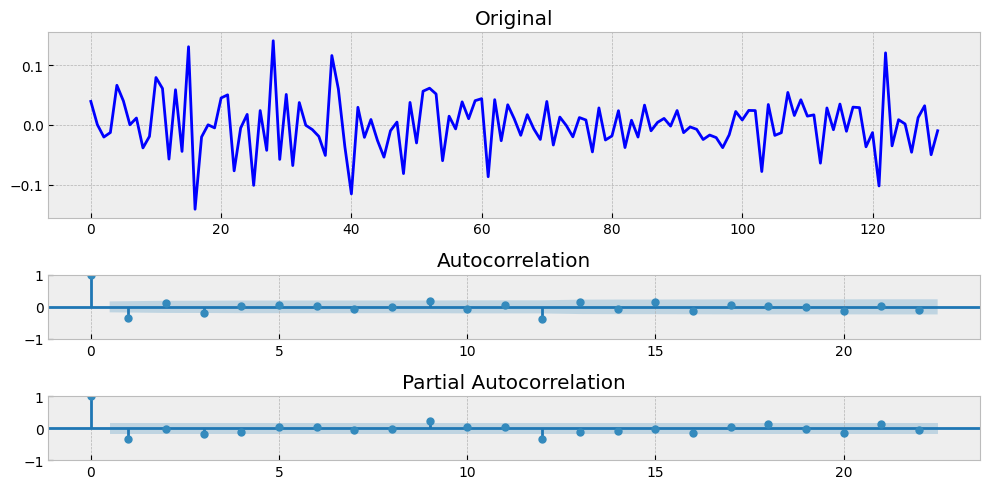

In [16]:
tsplot(airlines)

##### ряд стал стационарным, теперь дорабатываю словарь с сериями

In [17]:
series['International airline passengers'] = airlines

In [18]:
df_test(series)

Monthly sales of company X	p-value=0.024
 OK 	 - ряд стационарен  

Monthly Boston armed robberies	p-value=0.0
 OK 	 - ряд стационарен  

International airline passengers	p-value=0.0002
 OK 	 - ряд стационарен  

Weekly closings of the Dow-Jones	p-value=0.0
 OK 	 - ряд стационарен  



## Теперь все ряды являются стационарными